In [2]:
batches = {
    "Data Processor": {"name": "data_processor", "batch_id": "2117_batch"},
    "Model Converter": {"name": "model_converter", "batch_id": "7121_batch"},
    "Sketch Generator": {"name": "sketch_generator", "batch_id": "2172_batch"},
}


def get_stage_name(file_name):
    core_name = file_name.replace("clean_", "").replace("_batch.csv", "")

    # Split the remaining string by underscores
    parts = core_name.split("_")

    # Capitalize the first letter of each part and join them with a space
    task_name = " ".join(part.capitalize() for part in parts[:-1])

    return task_name

## Printing statistics


In [8]:
import pandas as pd
import numpy as np
import os

date = "10.28"
data_dir = "processed_data"  # Updated to remove date variable


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "median": df[column].median(),
        "maximum": df[column].max(),
        "minimum": df[column].min(),
    }
    if "token" in column:
        return {k: int(v) for k, v in stats.items()}
    return stats


# Prepare a list to store all data
all_data = []

# Process each batch
for stage_name, batch_info in batches.items():
    file_name = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
    file_path = os.path.join(data_dir, file_name)

    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)
        print(f"- {stage_name}")

        # Calculate statistics for each specified column
        stats = {
            "overall_tokens": calculate_stats(df, "total_tokens"),
            "input_tokens": calculate_stats(df, "prompt_tokens"),
            "output_tokens": calculate_stats(df, "completion_tokens"),
        }

        # Append the data to the list
        all_data.append(
            {
                "Stage": stage_name,
                "Overall Tokens Ave": stats["overall_tokens"]["average"],
                "Overall Tokens Med": stats["overall_tokens"]["median"],
                "Overall Tokens Max": stats["overall_tokens"]["maximum"],
                "Overall Tokens Min": stats["overall_tokens"]["minimum"],
                "Input Tokens Ave": stats["input_tokens"]["average"],
                "Input Tokens Med": stats["input_tokens"]["median"],
                "Input Tokens Max": stats["input_tokens"]["maximum"],
                "Input Tokens Min": stats["input_tokens"]["minimum"],
                "Output Tokens Ave": stats["output_tokens"]["average"],
                "Output Tokens Med": stats["output_tokens"]["median"],
                "Output Tokens Max": stats["output_tokens"]["maximum"],
                "Output Tokens Min": stats["output_tokens"]["minimum"],
            }
        )
    else:
        print(f"File not found: {file_path}")


# Create a DataFrame from the list
df_all_data = pd.DataFrame(all_data)

# Print the DataFrame as a table
print(df_all_data.to_string(index=False))

# Define the order of stages
stage_order = ["Data Processor", "Model Converter", "Sketch Generator"]

stage_abbr = {
    "Data Processor": "DP",
    "Model Converter": "MC",
    "Sketch Generator": "SG",
}

# Generate LaTeX table
latex_table = r"""
\begin{table}[!hp]
    \centering
    \resizebox{\textwidth}{!}{%
    \begin{tabular}{|l|r|r|r|r|r|r|r|r|r|r|r|r|}
    \hline
    \multicolumn{1}{|c|}{} &
      \multicolumn{4}{c|}{Overall Token Consumption} &
      \multicolumn{4}{c|}{Input Token Consumption} &
      \multicolumn{4}{c|}{Output Token Consumption} \\ \cline{2-13}
    \multicolumn{1}{|c|}{\multirow{-2}{*}{Stages}} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} &
      \multicolumn{1}{c|}{Ave} &
      \multicolumn{1}{c|}{Med} &
      \multicolumn{1}{c|}{Max} &
      \multicolumn{1}{c|}{Min} \\ \hline
"""

print("ALL DATA:\n", df_all_data)
# Add rows to the LaTeX table in the specified order
for stage in stage_order:
    row = df_all_data[df_all_data["Stage"] == stage].iloc[0]
    latex_table += f"    {stage_abbr[stage]} & {row['Overall Tokens Ave']} & {row['Overall Tokens Med']} & {row['Overall Tokens Max']} & {row['Overall Tokens Min']} & {row['Input Tokens Ave']} & {row['Input Tokens Med']} & {row['Input Tokens Max']} & {row['Input Tokens Min']} & {row['Output Tokens Ave']} & {row['Output Tokens Med']} & {row['Output Tokens Max']} & {row['Output Tokens Min']} \\\\ \\hline\n"


latex_table += rf"""
    \end{{tabular}}%
    }}
    \caption{{Token consumption regarding Overall, Input, and Output in three stages. {date}.}}
    \label{{tab:detailed_token_consumption_{date}}}
    \end{{table}}
"""

# Print the LaTeX table
print(latex_table)

output_dir = "tex"
os.makedirs(output_dir, exist_ok=True)
output_file = f"{output_dir}/tab_detailed_token_consumption_{date}.tex"
with open(output_file, "w") as file:
    file.write(latex_table)
print(f"LaTeX table saved to {output_file}")

- Data Processor
- Model Converter
- Sketch Generator
           Stage  Overall Tokens Ave  Overall Tokens Med  Overall Tokens Max  Overall Tokens Min  Input Tokens Ave  Input Tokens Med  Input Tokens Max  Input Tokens Min  Output Tokens Ave  Output Tokens Med  Output Tokens Max  Output Tokens Min
  Data Processor               10832                9433               25086                8560              8273              7030             18952              6562               2558               2319               6134               1953
 Model Converter                 688                 573                3949                 545               403               299              3433               299                285                274                516                246
Sketch Generator               13320               13906               17181                1840              9606             10011             13021              1361               3714               3916     

## Another way of printing statistics in a table


In [3]:
def print_summary_table(batches, data_dir="processed_data"):
    # Headers
    print("\n=== Summary Across All Stages ===")
    print(
        "{:<20} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}".format(
            "Stage",
            "Avg Time(s)",
            "Min Time(s)",
            "Max Time(s)",
            "Avg Tokens",
            "Min Tokens",
            "Max Tokens",
            "Success(%)",
        )
    )
    print("-" * 104)

    # Process each batch
    for task_name, batch_info in batches.items():
        input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
        df = pd.read_csv(f"{data_dir}/{input_csv}")

        # Calculate statistics
        time_stats = calculate_stats(df, "latency")
        token_stats = calculate_stats(df, "total_tokens")
        success_rate = (df["status"] == "success").mean() * 100

        # Print row
        print(
            "{:<20} {:<12.2f} {:<12.2f} {:<12.2f} {:<12.0f} {:<12.0f} {:<12.0f} {:<12.2f}".format(
                task_name,
                time_stats["average"],
                time_stats["minimum"],
                time_stats["maximum"],
                token_stats["average"],
                token_stats["minimum"],
                token_stats["maximum"],
                success_rate,
            )
        )


# Print the summary table
print_summary_table(batches)


=== Summary Across All Stages ===
Stage                Avg Time(s)  Min Time(s)  Max Time(s)  Avg Tokens   Min Tokens   Max Tokens   Success(%)  
--------------------------------------------------------------------------------------------------------
Data Processor       47.76        32.58        155.93       10832        8560         25086        90.00       
Model Converter      6.09         3.65         10.21        689          545          3949         100.00      
Sketch Generator     60.55        7.73         87.92        13321        1840         17181        36.67       


## Print statistics regarding overall, success, and failure


In [4]:
import pandas as pd
import numpy as np


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        # Handle NaN values before converting to int
        return {k: int(v) if not pd.isna(v) else 0 for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["status"] == status]  # Changed from "pass" to "status"
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def print_stats_table(df, task_name):
    # Calculate stats
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(
        df, "success"
    )  # Changed from "yes" to "success"
    failed_stats = calculate_stats_by_status(
        df, "error"
    )  # Changed from "no" to "error"
    success_rate = (
        df["status"] == "success"
    ).mean() * 100  # Changed from "pass" to "status"

    print(f"\n=== {task_name} ===")
    print(
        "{:<15} {:<15} {:<12} {:<12} {:<12}".format(
            "Status", "Metric", "Average", "Minimum", "Maximum"
        )
    )
    print("-" * 66)

    # Create rows for latency
    for status, stats in [
        ("Overall", overall_stats),
        ("Success", passed_stats),
        ("Error", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "latency",
                stats["latency"]["average"],
                stats["latency"]["minimum"],
                stats["latency"]["maximum"],
            )
        )

    print()

    # Create rows for total_tokens
    for status, stats in [
        ("Overall", overall_stats),
        ("Success", passed_stats),
        ("Error", failed_stats),
    ]:
        print(
            "{:<15} {:<15} {:<12.2f} {:<12.2f} {:<12.2f}".format(
                status,
                "total_tokens",
                stats["total_tokens"]["average"],
                stats["total_tokens"]["minimum"],
                stats["total_tokens"]["maximum"],
            )
        )

    print(f"\nSuccess rate: {success_rate:.2f}%")


# # Define batches
# batches = {
#     "Data Processor": {"name": "data_processor", "batch_id": "2117_batch"},
#     "Model Converter": {"name": "model_converter", "batch_id": "7121_batch"},
#     "Sketch Generator": {"name": "sketch_generator", "batch_id": "1730_batch"},
# }

# Load and print stats for each batch
data_dir = "processed_data"
for task_name, batch_info in batches.items():
    input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
    df = pd.read_csv(f"{data_dir}/{input_csv}")
    print_stats_table(df, task_name)


=== Data Processor ===
Status          Metric          Average      Minimum      Maximum     
------------------------------------------------------------------
Overall         latency         47.76        32.58        155.93      
Success         latency         44.75        32.58        155.93      
Error           latency         74.82        57.39        99.74       

Overall         total_tokens    10832.00     8560.00      25086.00    
Success         total_tokens    9731.00      8560.00      12951.00    
Error           total_tokens    20744.00     16783.00     25086.00    

Success rate: 90.00%

=== Model Converter ===
Status          Metric          Average      Minimum      Maximum     
------------------------------------------------------------------
Overall         latency         6.09         3.65         10.21       
Success         latency         6.09         3.65         10.21       
Error           latency         nan          nan          nan         

Overall     

## Plotting bar chart


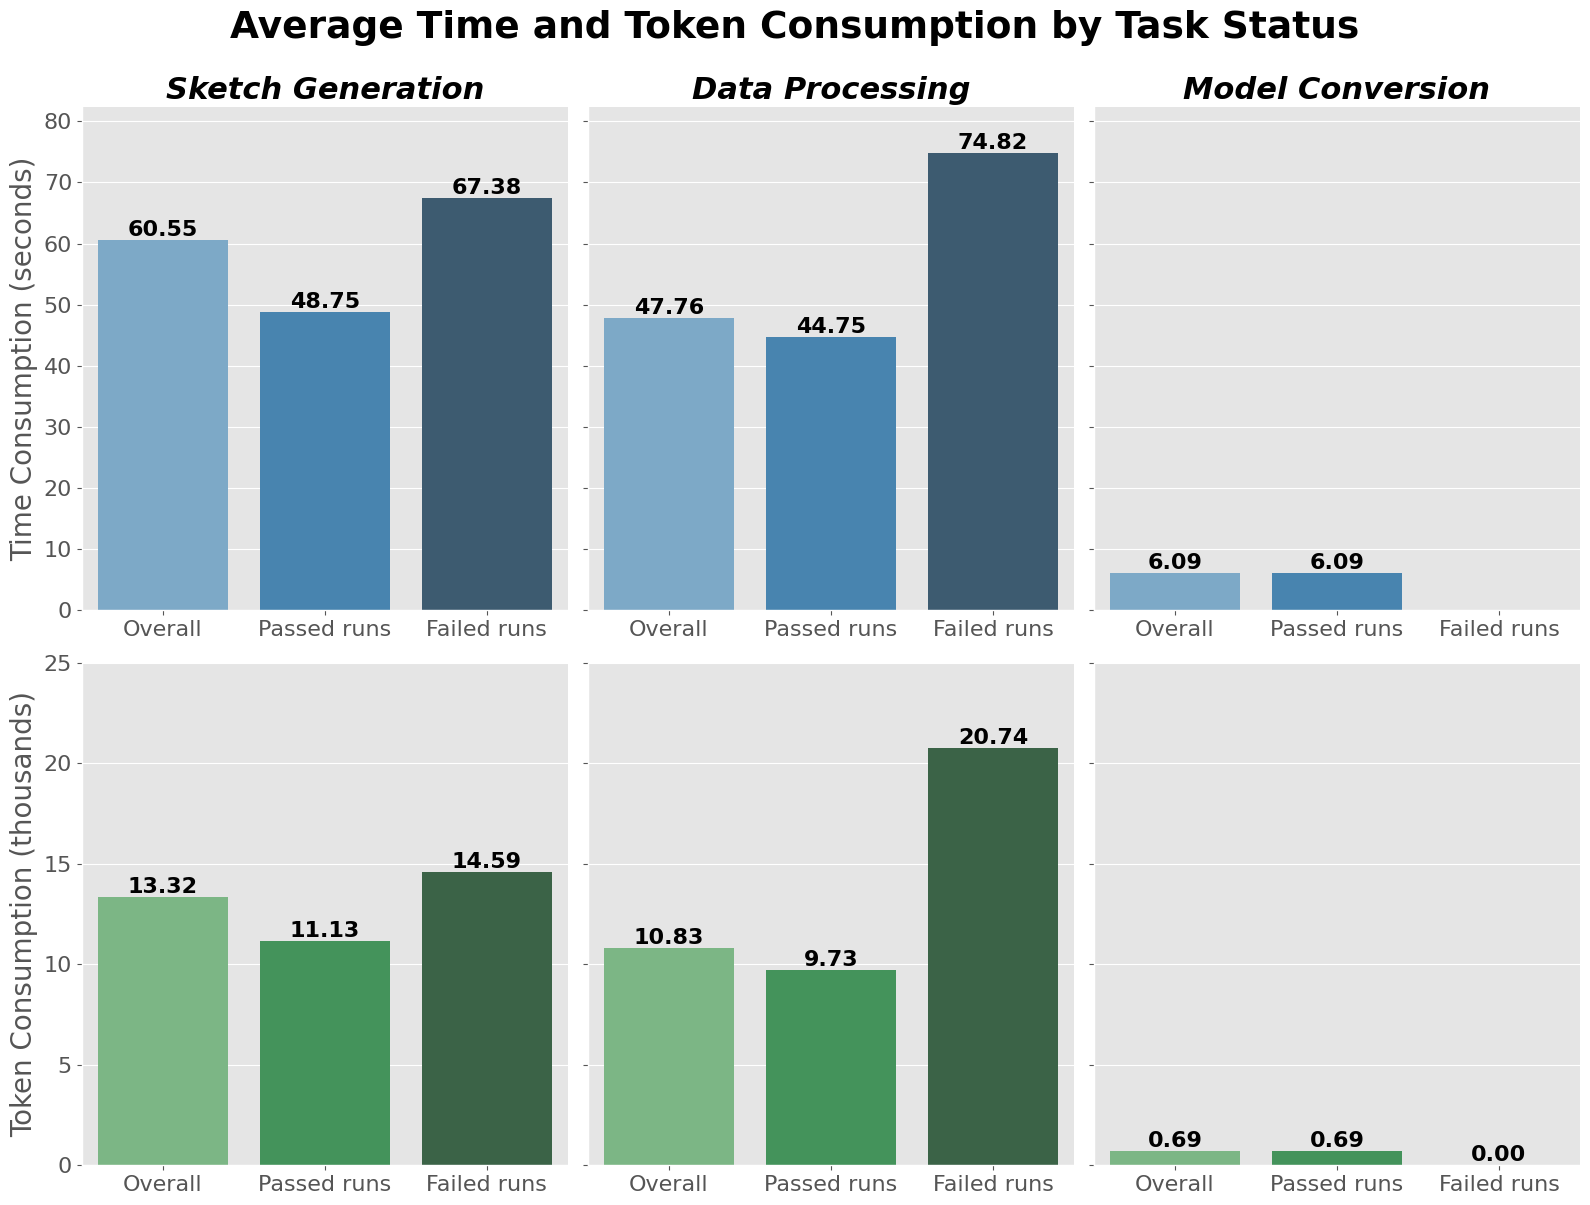

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define plot styling variables
SUPTITLE_SIZE = 27
TITLE_SIZE = 22
TICK_LABEL_SIZE = 16
ANNOTATION_SIZE = 16  # New variable for bar value annotations
AXIS_LABEL_SIZE = 20  # New variable for axis labels
FONT_WEIGHT = "bold"

# Load all datasets
data_dir = "processed_data"
df_sketch_generation = pd.read_csv(f"{data_dir}/clean_sketch_generator_2172_batch.csv")
df_data_processing = pd.read_csv(f"{data_dir}/clean_data_processor_2117_batch.csv")
df_model_conversion = pd.read_csv(f"{data_dir}/clean_model_converter_7121_batch.csv")


def calculate_stats(df, column):
    stats = {
        "average": df[column].mean(),
        "minimum": df[column].min(),
        "maximum": df[column].max(),
    }
    if "token" in column:
        # Handle NaN values before converting to int
        return {k: int(v) if not pd.isna(v) else 0 for k, v in stats.items()}
    return stats


def calculate_stats_by_status(df, status=None):
    if status is not None:
        subset = df[df["status"] == status]  # Changed from "pass" to "status"
    else:
        subset = df
    return {
        "total_tokens": calculate_stats(subset, "total_tokens"),
        "latency": calculate_stats(subset, "latency"),
    }


def prepare_data_for_plot(df, task_name):
    overall_stats = calculate_stats_by_status(df)
    passed_stats = calculate_stats_by_status(
        df, "success"
    )  # Changed from "yes" to "success"
    failed_stats = calculate_stats_by_status(
        df, "error"
    )  # Changed from "no" to "error"

    data = []
    for metric in ["latency", "total_tokens"]:
        for status, stats in [
            ("Overall", overall_stats),
            ("Passed runs", passed_stats),  # Changed label from "Passed" to "Success"
            ("Failed runs", failed_stats),  # Changed label from "Failed" to "Error"
        ]:
            data.append(
                {
                    "Task": task_name,
                    "Metric": metric,
                    "Status": status,
                    "Average": stats[metric]["average"],
                    "Minimum": stats[metric]["minimum"],
                    "Maximum": stats[metric]["maximum"],
                }
            )
    return pd.DataFrame(data)


# Prepare data for plotting
df_sketch = prepare_data_for_plot(df_sketch_generation, "Sketch Generation")
df_data = prepare_data_for_plot(df_data_processing, "Data Processing")
df_model = prepare_data_for_plot(df_model_conversion, "Model Conversion")

# Combine all data
df_all = pd.concat([df_sketch, df_data, df_model])

# Determine global y-axis limits
latency_max = df_all[df_all["Metric"] == "latency"]["Average"].max()
tokens_max = df_all[df_all["Metric"] == "total_tokens"]["Average"].max()

# Set the style
plt.style.use("ggplot")
sns.set_palette("muted")

# Plotting
tasks = df_all["Task"].unique()
fig, axes = plt.subplots(nrows=2, ncols=len(tasks), figsize=(16, 12), sharey="row")
plt.subplots_adjust(top=0.85)  # Add more space at the top

for col, task in enumerate(tasks):
    task_data = df_all[df_all["Task"] == task]

    # Plot latency
    ax_latency = axes[0, col]
    latency_data = task_data[task_data["Metric"] == "latency"]
    sns.barplot(
        x="Status",
        y="Average",
        data=latency_data,
        ax=ax_latency,
        hue="Status",
        palette="Blues_d",
        legend=False,
    )
    ax_latency.set_ylabel(
        "Time Consumption (seconds)" if col == 0 else "", fontsize=AXIS_LABEL_SIZE
    )
    ax_latency.set_ylim(0, latency_max * 1.1)
    ax_latency.set_title(
        task, fontsize=TITLE_SIZE, fontweight=FONT_WEIGHT, style="italic"
    )

    # Annotate latency bars
    for i, bar in enumerate(ax_latency.patches):
        yval = bar.get_height()
        ax_latency.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
            fontweight=FONT_WEIGHT,
            fontsize=ANNOTATION_SIZE,
        )

    # Plot total tokens
    ax_tokens = axes[1, col]
    tokens_data = task_data[task_data["Metric"] == "total_tokens"]
    sns.barplot(
        x="Status",
        y="Average",
        data=tokens_data,
        ax=ax_tokens,
        hue="Status",
        palette="Greens_d",
        legend=False,
    )
    ax_tokens.set_ylabel(
        "Token Consumption (thousands)" if col == 0 else "", fontsize=AXIS_LABEL_SIZE
    )
    ax_tokens.set_ylim(0, tokens_max * 1.1)

    # Set y-axis ticks manually
    y_ticks = ax_tokens.get_yticks()
    ax_tokens.set_yticks(y_ticks)
    ax_tokens.set_yticklabels([f"{int(tick/1000)}" for tick in y_ticks])

    # Annotate token bars
    for i, bar in enumerate(ax_tokens.patches):
        yval = bar.get_height()
        ax_tokens.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval/1000:.2f}",
            ha="center",
            va="bottom",
            fontweight=FONT_WEIGHT,
            fontsize=ANNOTATION_SIZE,
        )

    # Improve readability
    for ax in [ax_latency, ax_tokens]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", which="major", labelsize=TICK_LABEL_SIZE)
        ax.set_xlabel("")

# Add overall title
fig.suptitle(
    "Average Time and Token Consumption by Task Status",
    fontsize=SUPTITLE_SIZE,
    fontweight=FONT_WEIGHT,
    y=1,
)
plt.tight_layout()

plt.savefig(f"bar_plot_{date}.pdf", format="pdf", dpi=400, bbox_inches="tight")
plt.show()

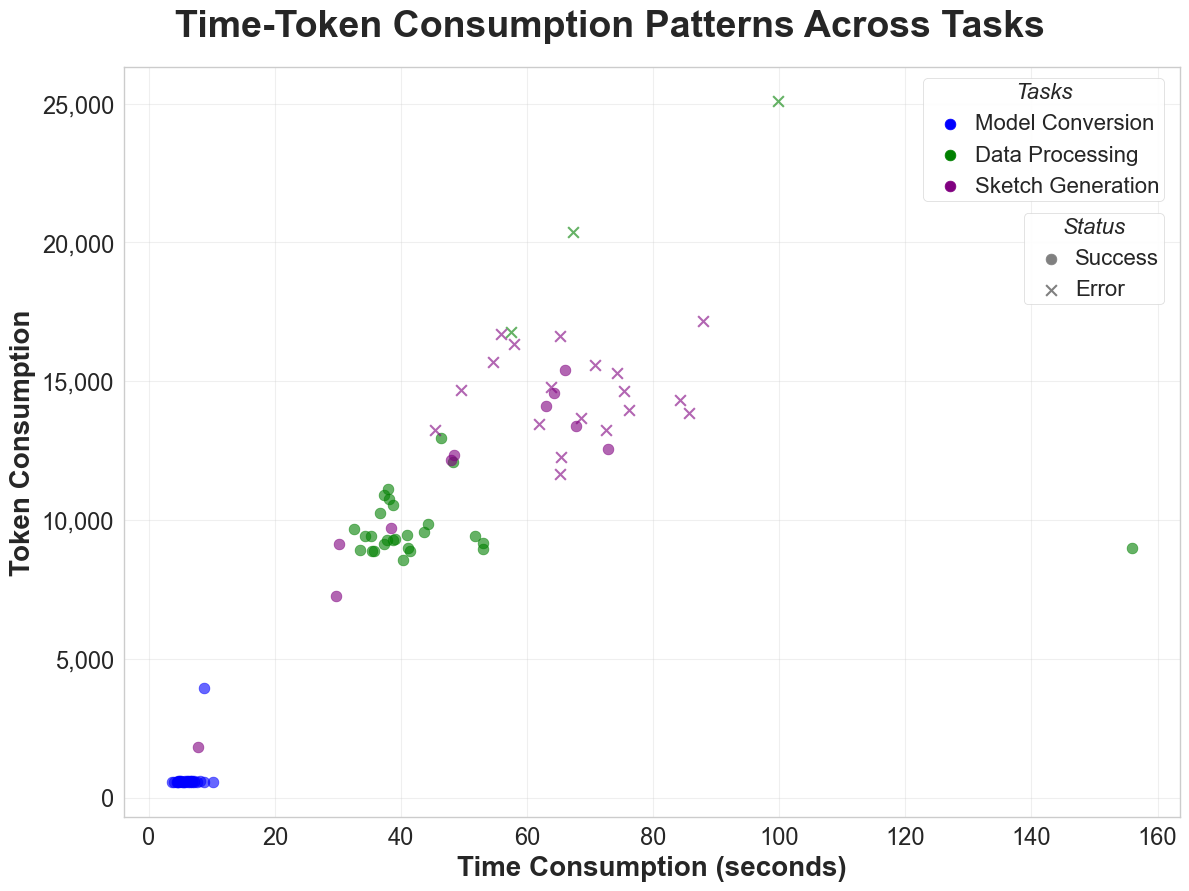

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker

# Style parameters
title_fontweight = 800
label_fontweight = 600
tick_fontweight = 400
legend_fontweight = "normal"
legend_fontweight2 = "normal"

title_fontsize = 27
label_fontsize = 20
tick_fontsize = 18
legend_fontsize = 16

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

# Define batches
batches = {
    "Sketch Generation": {"name": "sketch_generator", "batch_id": "2172_batch"},
    "Data Processing": {"name": "data_processor", "batch_id": "2117_batch"},
    "Model Conversion": {"name": "model_converter", "batch_id": "7121_batch"},
}

# Load and combine data
data_dir = "processed_data"
dataframes = []

for task_name, batch_info in batches.items():
    input_csv = f"clean_{batch_info['name']}_{batch_info['batch_id']}.csv"
    df = pd.read_csv(f"{data_dir}/{input_csv}")
    df["task"] = task_name
    dataframes.append(df)

df_combined = pd.concat(dataframes)

# Set the style
sns.set_style("whitegrid")

# Create the figure
plt.figure(figsize=(12, 9))

# Define colors for each task
task_colors = {
    "Model Conversion": "blue",
    "Data Processing": "green",
    "Sketch Generation": "purple",
}

# Plot each task with different colors and markers
for task, color in task_colors.items():
    task_data = df_combined[df_combined["task"] == task]

    # Plot successful runs
    success = task_data[task_data["status"] == "success"]
    plt.scatter(
        success["latency"],
        success["total_tokens"],
        color=color,
        alpha=0.6,
        label=task,
        marker="o",
        s=60,
    )

    # Plot failed runs
    failed = task_data[task_data["status"] == "error"]
    plt.scatter(
        failed["latency"],
        failed["total_tokens"],
        color=color,
        alpha=0.6,
        marker="x",
        s=60,
    )

# Labels and title
plt.xlabel(
    "Time Consumption (seconds)", fontsize=label_fontsize, fontweight=label_fontweight
)
plt.ylabel("Token Consumption", fontsize=label_fontsize, fontweight=label_fontweight)
plt.title(
    "Time-Token Consumption Patterns Across Tasks",
    fontsize=title_fontsize,
    loc="center",
    x=0.46,
    y=1.03,
    fontweight=title_fontweight,
)
plt.tick_params(axis="both", which="major", labelsize=17)

# Format axis numbers
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Create legend handles
task_handles = []
task_labels = []
status_handles = []
status_labels = []

# Collect task handles and labels
for task, color in task_colors.items():
    task_handles.append(plt.scatter([], [], color=color, marker="o", s=60))
    task_labels.append(task)

# Add status handles and labels
status_handles.append(plt.scatter([], [], color="gray", marker="o", s=60))
status_handles.append(plt.scatter([], [], color="gray", marker="x", s=60))
status_labels.extend(["Success", "Error"])

legend_title_prop = {
    "weight": legend_fontweight,
    "size": legend_fontsize,
    "style": "italic",
}

# Create legends
first_legend = plt.legend(
    task_handles,
    task_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 1.0),
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Tasks",
    title_fontproperties=legend_title_prop,
)

# Add the second legend for status markers
plt.gca().add_artist(first_legend)
plt.legend(
    status_handles,
    status_labels,
    loc="upper right",
    bbox_to_anchor=(0.995, 0.82),
    prop={"weight": legend_fontweight, "size": legend_fontsize},
    frameon=True,
    scatterpoints=1,
    markerscale=1,
    markerfirst=True,
    handletextpad=0.1,
    borderpad=0.2,
    edgecolor="lightgray",
    fancybox=True,
    shadow=False,
    framealpha=0.9,
    title="Status",
    title_fontproperties=legend_title_prop,
)

# Finishing touches
plt.grid(True, linestyle="-", alpha=0.3)
plt.tight_layout()
plt.savefig("scatter_plot.pdf", format="pdf", dpi=400)
plt.show()